## Model Term Explorer

This notebook calculates the prior's and model's energy prediction for various simple synthetic structures. For the most part the models have never actually seen a simple pair or triplet of amino acids so these should be taken with a large grain of salt.

The angles especially are sensitive to the internal bond lengths and may not produce realistic values.

In [204]:
import sys
sys.path.append("..")

import simulate
import os
import json
from module import dataset
from module import torchforcefield
import torch
import matplotlib.pyplot as plt
import numpy as np

# import moleculekit.molecule
# from moleculekit.molecule import Molecule
# from module import torchmd_cg_mappings

import mdtraj

import tempfile

## Configuration

In [205]:
# The model checkpoint to test
checkpoint_dir = "/home/argon/Stuff/harmonic_net_2025.04.06/model_high_density_benchmark_CA_only_2025.04.03_mix1_s100_CA_lj_bondNull_angleNull_dihedralNull_cutoff2_seq6_harBAD_termBAD100__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4_chunk120"

# TODO: Currently only one example of each type can be computed at a time
# Bonds to simulate
# bonds_to_test = [["GLY", "GLY"]]
bonds_to_test = [["LYS", "GLY"]] # Valid for BBA
# bonds_to_test = [["THR", "TRP"]] # Valid for Chignolin

# Non-bonded interactions
# nonbonded_to_test = [["ASP", "HIS"]]
nonbonded_to_test = [["TYR", "LEU"]] # Valid for BBA
# nonbonded_to_test = [["THR", "TRP"]] # Valid for Chignolin

# Angles
# angles_to_test = [["ARG", "ARG", "HIS"]]
angles_to_test = [["TYR", "LYS", "GLY"]] # Valid for BBA
# angles_to_test = [["GLY", "THR", "TRP"]] # Valid for Chignolin



# Generate paths for the checkpoint
prior_path = os.path.join(checkpoint_dir, "priors.yaml")
prior_params_path = os.path.join(checkpoint_dir, "prior_params.json")
device = "cpu"
use_box = False # Leave this false

## Functions

In [206]:
def make_mock_pdb(res_abbr):
    """Make a mock PDB file containing just carbon alphas"""
    top = mdtraj.Topology()
    c = top.add_chain()
    for i_res in res_abbr:
        r = top.add_residue(i_res, c)
        top.add_atom("CA", mdtraj.element.carbon, r)

    coords = np.array([[[0.0, 0.0, 0.39*i] for i in range(len(res_abbr))]])

    return mdtraj.Trajectory(coords, top)

In [207]:
def load_moc_mol(res_abbr, prior_path, prior_params):
    """ 'load' a mock molecule & generate the coresponding embeddings"""
    use_box = False
    with tempfile.TemporaryDirectory() as tmpdirname:
        tmp_path = os.path.join(tmpdirname, "tmp.pdb")
        make_mock_pdb(res_abbr).save(tmp_path)
        mol, embeddings = simulate.load_molecule(prior_path, prior_params, tmp_path, use_box)
    return mol, embeddings

## Plot bond energy

In [208]:
with open(f"{prior_params_path}", 'r') as file:
       prior_params = json.load(file)
assert len(bonds_to_test) == 1
mol, embeddings = load_moc_mol(bonds_to_test[0], prior_path, prior_params)

Prior Config: CA_lj_bondNull_angleNull_dihedralNull
Structure:    /tmp/tmpp0a0qjtf/tmp.pdb
Box:          <disabled>
Mol: (2, 3, 1) 0 []


In [209]:
model = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
calc = simulate.build_calc(model, mol, embeddings, use_box, temperature=300, device=device)

forces_ff = torchforcefield.TorchForceField(prior_path, mol, device=device, cutoff=None,
                                         terms=prior_params["forceterms"],
                                         exclusions=prior_params["exclusions"],
                                         use_box=use_box)

forces = simulate.CalcWrapper(forces_ff, [calc])

model_noh = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
model_noh.harmonic_model = None
calc_noh = simulate.build_calc(model_noh, mol, embeddings, use_box, temperature=300, device=device)

forces_noh = simulate.CalcWrapper(forces_ff, [calc_noh])


--- Model ---
 TorchMD_Net_Harmonic(
  (representation_model): TorchMD_GN_Ext(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=20, rbf_type=expnorm, trainable_rbf=True, activation=silu, embedding=Embedding(100, 128), neighbor_embedding=None, cutoff_lower=2.0, cutoff_upper=12.0, aggr=add, sequence_basis_radius=6)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (extra_output_models): ModuleDict()
  (harmonic_model): HarmonicModel(
    (bond_network): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (angle_network): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): SiLU()
      (2): Li

In [210]:
# One frame of coordinates
coords = torch.as_tensor(mol.coords.reshape(1,-1,3), device=device)

# Make the box and output tensors required for forces_ff.compute()
forces_out = torch.zeros_like(coords, device=device)
box = torch.zeros((3,3), device=device)

# Find the vector along the pair's bond
bond_vec = coords[0][1]-coords[0][0]
bond_vec /= torch.norm(bond_vec)
bond_vec

# Generate a linspace that explores stretching along that vector
linspace_coords = []
linspace_bonded = torch.linspace(2.0, 5.0, 500)
# linspace_bonded = torch.linspace(1.5, 13.5, 1000)
for i in (linspace_bonded[:,None]*bond_vec):
    linspace_coords.append(torch.vstack([torch.zeros_like(i), i]))
linspace_coords = torch.concatenate(linspace_coords).reshape(-1,2,3)

In [211]:
# Calculate the prior potential energy along the linspace
prior_pot_values = []
for i in linspace_coords:
    prior_pot_values.append(forces.ff.compute(i[None,:,:], box, forces_out))
prior_pot_values = torch.cat(prior_pot_values).numpy().flatten()

In [212]:
# Calculate the non-harmonic potential energy along the linspace
pot_values_noh = []
for i in linspace_coords:
    pot_values_noh.append(forces_noh.compute(i[None,:,:], box, forces_out))
pot_values_noh = torch.cat(pot_values_noh).numpy()

In [213]:
# Calculate the combined potential energy along the linspace
pot_values = []
for i in linspace_coords:
    pot_values.append(forces.compute(i[None,:,:], box, forces_out))
pot_values = torch.cat(pot_values).numpy()
bond_pot_values = pot_values

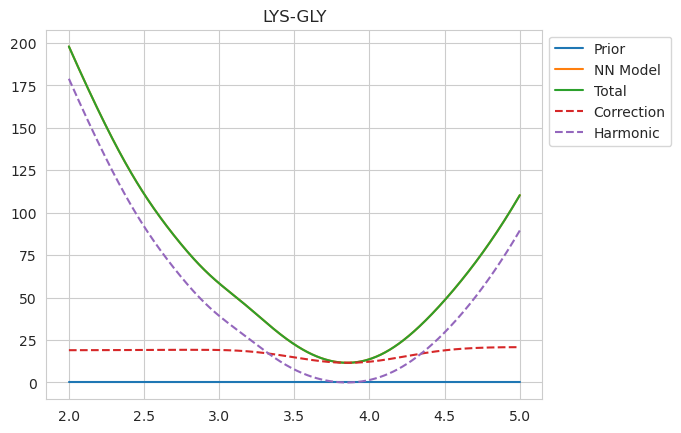

In [214]:
lin_bond = linspace_bonded.detach().cpu().numpy().flatten()

plt.plot(lin_bond, prior_pot_values, label="Prior")
plt.plot(lin_bond, pot_values-prior_pot_values, label="NN Model")
plt.plot(lin_bond, pot_values, label="Total")
plt.plot(lin_bond, pot_values_noh, label="Correction", linestyle="--")
plt.plot(lin_bond, pot_values-pot_values_noh, label="Harmonic", linestyle="--")
# plt.ylim(None,50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("-".join(mol.resname.tolist()))
pass

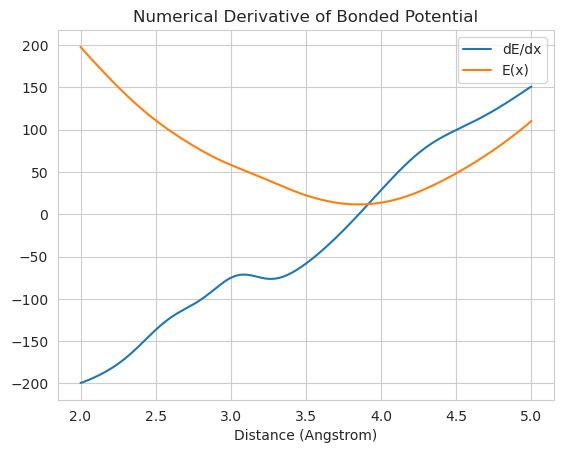

In [215]:
# Calculate the numerical derivative
numerical_derivative = np.gradient(pot_values, lin_bond)

# Plot the derivative
plt.plot(lin_bond, numerical_derivative, label="dE/dx")
plt.plot(lin_bond, pot_values, label="E(x)")

plt.title("Numerical Derivative of Bonded Potential")
plt.xlabel("Distance (Angstrom)")
plt.legend()
plt.show()

## Plot Non-Bonded energy

In [216]:
with open(f"{prior_params_path}", 'r') as file:
       prior_params = json.load(file)
assert len(nonbonded_to_test) == 1
mol, embeddings = load_moc_mol(nonbonded_to_test[0], prior_path, prior_params)

# Remove bonds
mol.bonds = np.empty((0,2))
# Make two chains
mol.segid = np.array([0, 1])

Prior Config: CA_lj_bondNull_angleNull_dihedralNull
Structure:    /tmp/tmp19x0pfmy/tmp.pdb
Box:          <disabled>
Mol: (2, 3, 1) 0 []


In [217]:
model = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
calc = simulate.build_calc(model, mol, embeddings, use_box, temperature=300, device=device)

# Assert that we really got two chains
if calc.sequence is not None:
    print("calc.sequence =", calc.sequence)
    assert calc.sequence[1] > calc.sequence[0] + 1

forces_ff = torchforcefield.TorchForceField(prior_path, mol, device=device, cutoff=None,
                                         terms=prior_params["forceterms"],
                                         exclusions=prior_params["exclusions"],
                                         use_box=use_box)

forces = simulate.CalcWrapper(forces_ff, [calc])

model_noh = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
model_noh.harmonic_model = None
calc_noh = simulate.build_calc(model_noh, mol, embeddings, use_box, temperature=300, device=device)

forces_noh = simulate.CalcWrapper(forces_ff, [calc_noh])

--- Model ---
 TorchMD_Net_Harmonic(
  (representation_model): TorchMD_GN_Ext(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=20, rbf_type=expnorm, trainable_rbf=True, activation=silu, embedding=Embedding(100, 128), neighbor_embedding=None, cutoff_lower=2.0, cutoff_upper=12.0, aggr=add, sequence_basis_radius=6)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (extra_output_models): ModuleDict()
  (harmonic_model): HarmonicModel(
    (bond_network): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (angle_network): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): SiLU()
      (2): Li

In [218]:
calc.dihedrals

tensor([], size=(0, 4), dtype=torch.int64)

In [219]:
# One frame of coordinates
coords = torch.as_tensor(mol.coords.reshape(1,-1,3), device=device)

# Make the box and output tensors required for forces_ff.compute()
forces_out = torch.zeros_like(coords, device=device)
box = torch.zeros((3,3), device=device)

# Find the vector along the pair's bond
bond_vec = coords[0][1]-coords[0][0]
bond_vec /= torch.norm(bond_vec)
bond_vec

# Generate a linspace that explores stretching along that vector
linspace_coords = []
linspace_nonbond = torch.linspace(2.0, 5.0, 500)
linspace_nonbond = torch.linspace(1.5, 13.5, 1000)
for i in (linspace_nonbond[:,None]*bond_vec):
    linspace_coords.append(torch.vstack([torch.zeros_like(i), i]))
linspace_coords = torch.concatenate(linspace_coords).reshape(-1,2,3)

In [220]:
# Calculate the prior potential energy along the linspace
prior_pot_values = []
for i in linspace_coords:
    prior_pot_values.append(forces.ff.compute(i[None,:,:], box, forces_out))
prior_pot_values = torch.cat(prior_pot_values).numpy().flatten()

In [221]:
# Calculate the combined potential energy along the linspace
pot_values = []
for i in linspace_coords:
    pot_values.append(forces.compute(i[None,:,:], box, forces_out))
pot_values = torch.cat(pot_values).numpy()

In [222]:
# Calculate the non-harmonic potential energy along the linspace
pot_values_noh = []
for i in linspace_coords:
    pot_values_noh.append(forces_noh.compute(i[None,:,:], box, forces_out))
pot_values_noh = torch.cat(pot_values_noh).numpy()

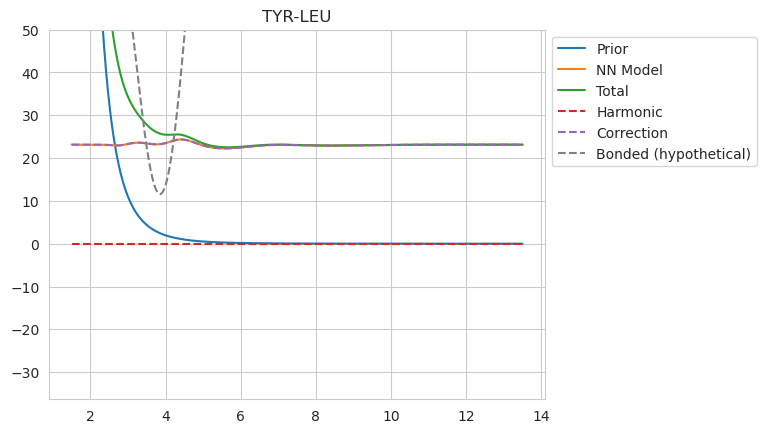

In [223]:
plt.plot(linspace_nonbond.detach().cpu().numpy().flatten(), prior_pot_values, label="Prior")
plt.plot(linspace_nonbond.detach().cpu().numpy().flatten(), pot_values-prior_pot_values, label="NN Model")
plt.plot(linspace_nonbond.detach().cpu().numpy().flatten(), pot_values, label="Total")
plt.plot(linspace_nonbond.detach().cpu().numpy().flatten(), pot_values-pot_values_noh, label="Harmonic", linestyle="--")
plt.plot(linspace_nonbond.detach().cpu().numpy().flatten(), pot_values_noh-prior_pot_values, label="Correction", linestyle="--")
# Show the bonded curve so we can see if it was inapproprately replicated here
plt.plot(lin_bond, bond_pot_values, label="Bonded (hypothetical)", linestyle="--", color="grey")
plt.ylim(None,50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("-".join(mol.resname.tolist()))
pass

## Angle Term Energy

In [224]:
with open(f"{prior_params_path}", 'r') as file:
       prior_params = json.load(file)
assert len(angles_to_test) == 1
mol, embeddings = load_moc_mol(angles_to_test[0], prior_path, prior_params)

Prior Config: CA_lj_bondNull_angleNull_dihedralNull
Structure:    /tmp/tmp0vhn7s8z/tmp.pdb
Box:          <disabled>
Mol: (3, 3, 1) 0 []


In [225]:
model = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
calc = simulate.build_calc(model, mol, embeddings, use_box, temperature=300, device=device)

forces_ff = torchforcefield.TorchForceField(prior_path, mol, device=device, cutoff=None,
                                         terms=prior_params["forceterms"],
                                         exclusions=prior_params["exclusions"],
                                         use_box=use_box)

forces = simulate.CalcWrapper(forces_ff, [calc])

model_noh = simulate.load_model(os.path.join(checkpoint_dir, "checkpoint-best.pth"), device=device)
model_noh.harmonic_model = None
calc_noh = simulate.build_calc(model_noh, mol, embeddings, use_box, temperature=300, device=device)

forces_noh = simulate.CalcWrapper(forces_ff, [calc_noh])

--- Model ---
 TorchMD_Net_Harmonic(
  (representation_model): TorchMD_GN_Ext(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=20, rbf_type=expnorm, trainable_rbf=True, activation=silu, embedding=Embedding(100, 128), neighbor_embedding=None, cutoff_lower=2.0, cutoff_upper=12.0, aggr=add, sequence_basis_radius=6)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (extra_output_models): ModuleDict()
  (harmonic_model): HarmonicModel(
    (bond_network): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (angle_network): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): SiLU()
      (2): Li

In [226]:
# Generate an arc of coordinates from 0 to pi
angle_linspace = np.linspace(0,np.pi,101)
angle_coords = [[[0,0,1],[0,0,0],[0,np.sin(i),np.cos(i)]] for i in angle_linspace]


angle_bond_length = 3.85
angle_coords = torch.as_tensor(angle_coords, device=device, dtype=torch.float32)
angle_coords = angle_coords*angle_bond_length

# plt.scatter(angle_coords[:,2,2], angle_coords[:,2,1])


# Make the box and output tensors required for forces_ff.compute()
forces_out = torch.zeros_like(angle_coords, device=device)
box = torch.zeros((3,3), device=device)

In [227]:
# Calculate the prior potential energy along the linspace
prior_pot_values = []
for i in angle_coords:
    # print(i[None,:,:])
    prior_pot_values.append(forces.ff.compute(i[None,:,:], box, forces_out))
prior_pot_values = torch.cat(prior_pot_values).numpy().flatten()

In [228]:
# Calculate the combined potential energy along the linspace
pot_values = []
for i in angle_coords:
    pot_values.append(forces.compute(i[None,:,:], box, forces_out))
pot_values = torch.cat(pot_values).numpy()

In [229]:
# Calculate the non-harmonic potential energy along the linspace
pot_values_noh = []
for i in angle_coords:
    pot_values_noh.append(forces_noh.compute(i[None,:,:], box, forces_out))
pot_values_noh = torch.cat(pot_values_noh).numpy()

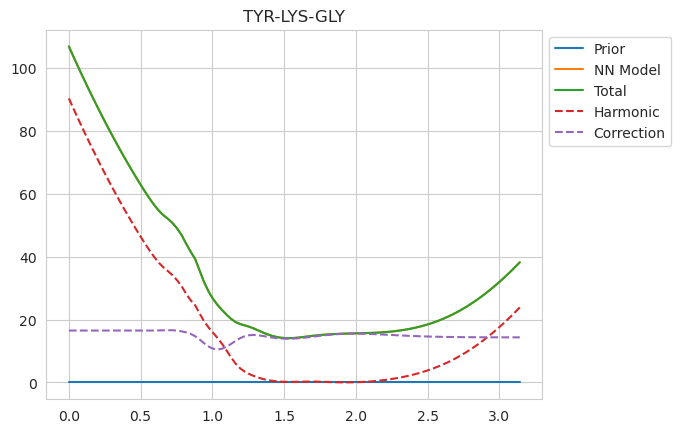

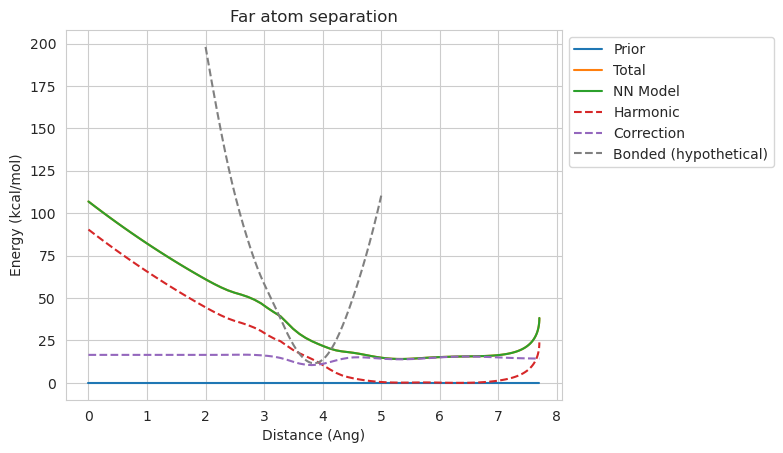

In [230]:
plt.plot(angle_linspace, prior_pot_values, label="Prior")
plt.plot(angle_linspace, pot_values-prior_pot_values, label="NN Model")
plt.plot(angle_linspace, pot_values, label="Total")
plt.plot(angle_linspace, pot_values-pot_values_noh, label="Harmonic", linestyle="--")
plt.plot(angle_linspace, pot_values_noh-prior_pot_values, label="Correction", linestyle="--")
# plt.ylim(None,50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("-".join(mol.resname.tolist()))
plt.show()



plt.title("Far atom separation")
plt.ylabel("Energy (kcal/mol)")
plt.xlabel("Distance (Ang)")

far_atoms_linspace = 2*angle_bond_length*np.sin(angle_linspace/2)
plt.plot(far_atoms_linspace, prior_pot_values, label="Prior")
plt.plot(far_atoms_linspace, pot_values, label="Total")
plt.plot(far_atoms_linspace, pot_values-prior_pot_values, label="NN Model")
plt.plot(far_atoms_linspace, pot_values-pot_values_noh, label="Harmonic", linestyle="--")
plt.plot(far_atoms_linspace, pot_values_noh-prior_pot_values, label="Correction", linestyle="--")
# Show the bonded curve so we can see if it was inapproprately replicated here
plt.plot(lin_bond, bond_pot_values, label="Bonded (hypothetical)", linestyle="--", color="grey")
# plt.ylim(None,50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pass

In [124]:
raise Exception("STOP")

Exception: STOP

Comparing several models by manually collecting their potential energy values...

In [ ]:
# pot_values_basic_prior = pot_values
# pot_values_manual_prior = pot_values
# pot_values_manual_meta_prior = pot_values
# pot_values_subsectC_prior = pot_values

(0.0, 50.0)

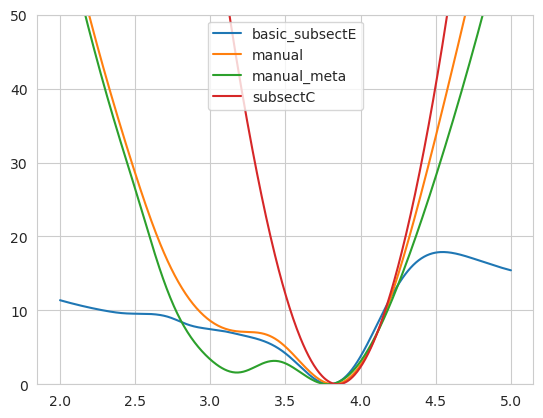

In [ ]:
plt.plot(linspace_bonded.detach().cpu().numpy().flatten(), pot_values_basic_prior-np.min(pot_values_basic_prior), label="basic_subsectE")
plt.plot(linspace_bonded.detach().cpu().numpy().flatten(), pot_values_manual_prior-np.min(pot_values_manual_prior), label="manual")
plt.plot(linspace_bonded.detach().cpu().numpy().flatten(), pot_values_manual_meta_prior-np.min(pot_values_manual_meta_prior), label="manual_meta")
plt.plot(linspace_bonded.detach().cpu().numpy().flatten(), pot_values_subsectC_prior-np.min(pot_values_subsectC_prior), label="subsectC")
plt.legend()
plt.ylim(0, 50)